# EfficientDet for Edge-Aware Image Segmentation

In this task - one should implement a part of the one of the state-of-the-art NN architecture for dense predictions - [EfficientDet](https://arxiv.org/pdf/1911.09070.pdf) - called the BiFPN feature combinator. Then one should use the features from the FPN as an input to two heads: one for an person segmentation (single class) and other for an edge detection. This network should be trained on the PennFundan dataset with traditional augmentations.

## Dataset and augmentations (2pt)

Our dataset is a modified [PennFundan](https://www.cis.upenn.edu/~jshi/ped_html/) dataset (known from a previous task). For each image $I$ in this dataset and its pedestrians masks $M^{I}_{1}, ... M^{I}_{n}$ we generate a dataset consisting of $n$ new images and their corresponding masks (both person and edge ones): $\{(DI^{I}_{1} , DM^{I}_{1}, DE^{I}_{1}),  ... (DI^{I}_{n}, DM^{I}_{n}, DE^{I}_{n})\}$. For each $i = 1, .. ,n$, $DI^{I}_{i}$ is obtained by first extending the minimal bounding box encircling a mask $M^{I}_{i}$ by 12 pixels (if possible, if not - by a maximal possible number of pixels) in each direction and then resizing it to a square of size $(128, 128)$. Mask $DM^{I}_{i}$ is obtained in the same manner and it is downscaled to the size of $(64, 64)$. For each mask - its edge mask $DE^{I}$ is computed as a mask for those pixels $p$ in the person mask for which there exist two pixels $p_m, p_b$ distant from $p$ by at most 2 in $L^{\inf}$ distance on the image for which $p_m$ belongs to a person mask and $p_b$ does not.

Your task is to implement a function `get_edge_of_mask` that extracts the edge of the mask (1pt).

**Hint**: the edge mask may be easily computed using convolution.

**Clarification**:

$$L^{\inf}((x_1^1, x_2^1), (x_1^2, x_2^2) = \max_{i = 1, 2} |x_i^1 - x_i^2|.$$

One should also implement a set of at least three standard image / mask augmentations (e.g., flips, rotations, etc.). They should be applied to image, person mask and edge mask in a consistent manner (1pt).

##BiFPN (3pts)

One should implement a BIFPN module with a pixel-wise weighted feature fusion as described in section 3.3 of [this](https://arxiv.org/pdf/1911.09070.pdf) paper (3pts). The fusion weighting function (e.g., softmax, unbounded, etc.) is to be decided by the student.

**Hint**: if a model explodes, try to use a bounded activation functions. Using pixel-wise fusion strategy might also cause the training to have a rough start - so wait a few epochs before you decide to stop the training.

## Full Model (1pts)

A full model should consist of:
- an [EfficientNet-B0](https://arxiv.org/abs/1905.11946) backbone,
- a feature fusion consisting of multiple consecutive BiFPN blocks (number of blocks is to be decided by the student, number between 2 and 4 is suggested),
- a final feature merging (e.g., a standard feature pyramid) that is fed to two classification heads of size $(64, 64)$ - one for pixel-wise person mask prediction and other - for edge prediction.

**Hint**: Feature merging might accept as an input not only output from the final BiFPN block. It might be useful to reuse outputs from the intermediate BiFPN blocks or even outputs from the backbone itself.

## Training (4pts)

You should train your model on tuples $\{(DI^{I}_{1} , DM^{I}_{1}, DE^{I}_{1}),  ... (DI^{I}_{n}, DM^{I}_{n}, DE^{I}_{n})\}$ obtained from a first ($70\%$) of images validate on the following $15\%$ and test on the rest. The loss function should be a binary crossentropy. The full loss should be equal to:

$$Loss = MaskLossBCE + \lambda EdgeLossBCE,$$

Train your model for different values of $\lambda < 0.1$ (test at least 3 different positive values and case when $\lambda = 0$) and compare the results using Person IOU metric on a mask prediction and Edge IOU on edge prediction tasks. At least one of your models should exceed $0.7$ of Person IOU for a mask prediction task (1pt). These results should be presented in a form of a short report (2pts).

**Hint:** IOU score is dependent on a threshold applied to a continuos prediction of your model. A proper calibration on this threshold might help you to achieve better results. Be careful however - not to overfit to your data.

The report should include:
- analysis of model results vs different values of $\lambda$. This comparison might be performed on a single, selected model architecture. For all of these models - show the relation between Edge IOU and Person IOU values, on both train and test datasets (or any other if you split the train into appropriate subsets) (1pt),
- analysis if Edge IOU visually correlates with a mask prediction and edge prediction quality by a visual analysis of the 5 best and the 5 worst examples w.r.t. to this metric, (1pt).

The final (1pt) will be awarded by a proper implementation of a loss function and appropriate IOU metrics.

Good luck!

### Dataset preparation

In [1]:
# Dataset downloading:

!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

# Dataset unzipping:
!unzip PennFudanPed.zip

--2022-06-20 20:05:12--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M   109MB/s    in 0.5s    

2022-06-20 20:05:13 (109 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotatio

In [2]:
DATASET_PATH = "./PennFudanPed"

In [3]:
import numpy as np
import os


TRAIN_PERCENTAGE = 0.7
VAL_PERCENTAGE = 0.15
TEST_PERCENTAGE = 0.15


imgs_filenames = list(sorted(os.listdir(os.path.join(DATASET_PATH, "PNGImages"))))
masks_filenames = list(sorted(os.listdir(os.path.join(DATASET_PATH, "PedMasks"))))

imgs_paths = [
    os.path.join(DATASET_PATH, "PNGImages", img_filename)
    for img_filename in imgs_filenames
]

masks_paths = [
    os.path.join(DATASET_PATH, "PedMasks", mask_filename)
    for mask_filename in masks_filenames
]

train_split_index = int(len(imgs_paths) * TRAIN_PERCENTAGE)
val_split_index = int(len(imgs_paths) * (TRAIN_PERCENTAGE + VAL_PERCENTAGE))

train_imgs_paths = imgs_paths[:train_split_index]
train_masks_paths = masks_paths[:train_split_index]

val_imgs_paths = imgs_paths[train_split_index:val_split_index]
val_masks_paths = masks_paths[train_split_index:val_split_index:]

test_imgs_paths = imgs_paths[val_split_index:]
test_masks_paths = masks_paths[val_split_index:]

In [4]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F

SINGLE_IMAGE_PIXEL_EXTENSION = 12
EDGE_WINDOW_SIZE = 2


import torch

# TODO: implement a function extracting edge from a mask
def get_edge_of_mask(mask, window_size):
    refl_pad = nn.ReflectionPad2d(window_size)
    kHW = 2*window_size+1
    weights = torch.ones((1, 1, kHW, kHW))
    
    mask = torch.Tensor(mask)
    mask = mask[None, None, ...]
    mask = refl_pad(mask)

    with torch.no_grad():
        out = F.conv2d(mask, weights)

    out = torch.squeeze(out)
    out = out.numpy()
    return (out != 0) & (out != kHW ** 2)


def load_images_masks_and_edges_from_path(
    img_path, 
    mask_path,
    pixel_extension=SINGLE_IMAGE_PIXEL_EXTENSION,
    edge_window_size=EDGE_WINDOW_SIZE,
    ):
    # Loading image and mask
    mask = np.array(Image.open(mask_path))
    image = np.array(Image.open(img_path))
    obj_ids = np.unique(mask)
    
    # Masks extraction
    masks = mask == obj_ids[:, None, None]
    img_size = masks[0].shape

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    extended_boxes = []
    extended_images = []
    extended_masks = []
    extended_edges = []
    for i in range(1, num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1]) 
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
        x_min_ex = max(xmin - pixel_extension, 0)
        x_max_ex = min(xmax + pixel_extension, img_size[1])
        y_min_ex = max(ymin - pixel_extension, 0)
        y_max_ex = min(ymax + pixel_extension, img_size[0])
        extended_boxes.append([x_min_ex, y_min_ex, x_max_ex, y_max_ex])
        extended_images.append(image[y_min_ex:y_max_ex, x_min_ex:x_max_ex])
        new_mask = masks[i, y_min_ex:y_max_ex, x_min_ex:x_max_ex]
        extended_masks.append(new_mask)
        # Application of get_edge_of_mask:
        extended_edges.append(get_edge_of_mask(new_mask, edge_window_size))

    return extended_boxes, extended_images, extended_masks, extended_edges

Visualizing example image, mask and edges:

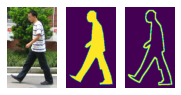

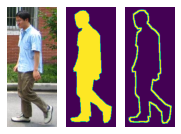

In [5]:
import matplotlib.pyplot as plt


extended_boxes, extended_images, extended_masks, extended_edges = load_images_masks_and_edges_from_path(
    train_imgs_paths[0], train_masks_paths[0], 12
)


for image, mask, edge in zip(extended_images, extended_masks, extended_edges):
    plt.figure(figsize=(3, 9))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(edge)
    plt.axis('off')
    plt.show()

Dataset loading:

In [6]:
def load_data_from_paths(img_paths, mask_paths):
    extended_boxes, extended_images, extended_masks, extended_edges = [], [], [], []
    for img_path, mask_path in zip(img_paths, mask_paths):
        new_boxes, new_images, new_masks, new_edges = load_images_masks_and_edges_from_path(
            img_path, mask_path,
        )
        extended_boxes.extend(new_boxes)
        extended_images.extend(new_images)
        extended_masks.extend(new_masks)
        extended_edges.extend(new_edges)
    return extended_boxes, extended_images, extended_masks, extended_edges


train_boxes, train_images, train_masks, train_edges = load_data_from_paths(
    img_paths=train_imgs_paths,
    mask_paths=train_masks_paths,
)


val_boxes, val_images, val_masks, val_edges = load_data_from_paths(
    img_paths=val_imgs_paths,
    mask_paths=val_masks_paths,
)


test_boxes, test_images, test_masks, test_edges = load_data_from_paths(
    img_paths=test_imgs_paths,
    mask_paths=test_masks_paths,
)

Dataset transformations:

In [7]:
from typing import List, Tuple, Dict, Optional, Union

import torch
import torchvision
from torch import nn, Tensor
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as T, InterpolationMode


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask, edge):
        for t in self.transforms:
            image, mask, edge = t(image, mask, edge)
        return image, mask, edge


# Implement a Random Horizontal Flip on triple (image, mask, edge)
class RandomHorizontalFlip(torch.nn.Module):
    def __init__(self, p=0.5) -> None:
        super().__init__()
        self.p = p

    def forward(
        self, 
        image: Tensor,
        mask: Tensor, 
        edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        if np.random.random() < self.p:
            return F.hflip(image), F.hflip(mask), F.hflip(edge)
        else:
            return image, mask, edge


class ConvertImageDtype(nn.Module):
    def __init__(self, dtype: torch.dtype) -> None:
        super().__init__()
        self.dtype = dtype

    def forward(
            self, 
            image: Tensor,
            mask: Tensor, 
            edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        image = F.convert_image_dtype(image, self.dtype)
        return image, mask.to(torch.float32), edge.to(torch.float32)


# EfficientNet Normalization function
class Normalize(torch.nn.Module):
    def __init__(self):
        super(Normalize, self).__init__()
        self.normalizer = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def forward(
        self, 
        image: Tensor,
        mask: Tensor, 
        edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        return self.normalizer(image), mask, edge


class ToNumpy(torch.nn.Module):
    def __init__(self):
        super(ToNumpy, self).__init__()

    def forward(
        self, 
        image: Tensor,
        mask: Tensor, 
        edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        return (
            torch.from_numpy(image.astype('float32').transpose([2, 0, 1])) / 255.0,
            torch.from_numpy(mask)[None, ...],
            torch.from_numpy(edge)[None, ...],
        )


# Implement resizing image -> (128, 128), edge -> (64, 64), mask -> (64, 64)
class Upsample(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(
        self, 
        image: Tensor,
        mask: Tensor, 
        edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        image = F.resize(image, (128, 128))
        mask = F.resize(mask, (64, 64))
        edge = F.resize(edge, (64, 64))

        return image, mask, edge



# TODO: implement two more transformations (e.g., rotations, color jitter, etc.)
class ColorJitter(torch.nn.Module):
    def __init__(self, brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1):
        super().__init__()
        self.color_jitter = T.ColorJitter(brightness, contrast, saturation, hue)
    def forward(
        self, 
        image: Tensor,
        mask: Tensor, 
        edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        image = self.color_jitter(image)
        
        return image, mask, edge

    
class RandomRotation(torch.nn.Module):
    def __init__(self, degree=5):
        super().__init__()
        self.degree = degree

    def forward(
        self, 
        image: Tensor,
        mask: Tensor, 
        edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        angle = np.random.uniform(-self.degree, self.degree)

        image = F.rotate(image, angle)
        mask = F.rotate(mask, angle)
        edge = F.rotate(edge, angle)

        return image, mask, edge    

Torch Datasets creation:

In [8]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        images,
        masks,
        edges,
        transforms,
    ):
        self.transforms = transforms
        self.images = images
        self.masks = masks
        self.edges = edges

    def __getitem__(self, idx):
        return self.transforms(
            self.images[idx],
            self.masks[idx], 
            self.edges[idx],
        )

    def __len__(self):
        return len(self.images)

# Extend this list with at least two additional transformations
train_transform = Compose(
    [
        ToNumpy(),
        ConvertImageDtype(torch.float32),
        Normalize(),
        RandomHorizontalFlip(),
        Upsample(),
        ColorJitter(),
        RandomRotation()
    ]
)

# This should remain the same.
test_transform = Compose(
    [
        ToNumpy(),
        ConvertImageDtype(torch.float32),
        Normalize(),
        Upsample(),
    ]
)


train_dataset = PennFudanDataset(
    images=train_images,
    masks=train_masks,
    edges=train_edges,
    transforms=train_transform,
)


val_dataset = PennFudanDataset(
    images=val_images,
    masks=val_masks,
    edges=val_edges,
    transforms=test_transform,
)


test_dataset = PennFudanDataset(
    images=test_images,
    masks=test_masks,
    edges=test_edges,
    transforms=test_transform,
)

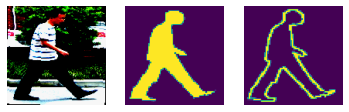

In [9]:
image, mask, edge = train_dataset[0]
image, mask, edge = image.permute(1, 2, 0), mask.squeeze(), edge.squeeze()

plt.figure(figsize=(6, 18))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(edge)
plt.axis('off')
plt.show()

IOU implementation:

In [10]:
def iou(y_true, y_pred, threshold):
    y_pred = y_pred > threshold
    iou_ = 0

    for im_true, im_pred in zip(y_true, y_pred):
        inter = torch.count_nonzero(im_true * im_pred)
        union = torch.count_nonzero(im_true + im_pred)
        iou_ += inter/union

    return iou_/len(y_true)

# Note on using `efficientnet_pytorch`

The code below shows how to use `efficientnet_pytorch` to extract intermediate layers from an `efficient_net_model`:

```
!pip install efficientnet_pytorch


from efficientnet_pytorch import EfficientNet

EFFICIENT_NET_MODEL_NAME = 'efficientnet-b0'
model = EfficientNet.from_pretrained(EFFICIENT_NET_MODEL_NAME)
test_tensor = torch.tensor(np.random.normal(size=(1, 3, 128, 128)).astype('float32'))
intermediate_outputs_dict = model.extract_endpoints(test_tensor)
ilustrating_dict = {
    key_: intermediate_outputs_dict[key_].shape
    for key_ in intermediate_outputs_dict
}
print(ilustrating_dict)

Output:
{
  'reduction_1': torch.Size([1, 16, 64, 64]), 
  'reduction_2': torch.Size([1, 24, 32, 32]), 
  'reduction_3': torch.Size([1, 40, 16, 16]), 
  'reduction_4': torch.Size([1, 112, 8, 8]), 
  'reduction_5': torch.Size([1, 320, 4, 4]), 
  'reduction_6': torch.Size([1, 1280, 4, 4]),
}
```

One can obviously use other implementations of an `EfficientNet` architectures.

## Model implementation:

In [11]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
from torch.nn.modules.container import ModuleList
import torch
import torch.nn.functional as nnF


DEVICE = 'cuda'


class Head(torch.nn.Module):
    # This module should accept either:
    # - output from the final BiFPN Block,
    # - outputs from all BiFPN blocks,
    # - all of above plus backbone outputs
    # And output tensor of shape (*, 1, 64, 64) - the final prediction output 
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1776, 1, kernel_size=3, padding='same')
        self.upsample = nn.Upsample((64, 64))

    def forward(self, nodes):
        nodes_ups = [self.upsample(node) for node in nodes]
        
        out = torch.cat(nodes_ups, dim=1)
        out = self.conv(out)

        return torch.sigmoid(out)


class Node(torch.nn.Module):
    def __init__(self, n, in_size, out_channels, kernel_size):
        super().__init__()        
        self.weights = nn.ParameterList([
                                         nn.Parameter(torch.ones(1, 1,  in_size, in_size))
                                         for _ in range(n)
                                         ])

        self.conv = nn.Conv2d(64, out_channels, kernel_size=kernel_size, padding='same')

    def forward(self, *xs):
        weights_sum  = sum(self.weights)
        out = []

        for weight, x in zip(self.weights, xs):
            out.append(weight*x)
            
        out = sum([o/weights_sum for o in out])

        return self.conv(out)


class BiFPNModule(torch.nn.Module):
    # This module should accepts list of tensors from different levels 
    # (e.g., from a backbone or a previous BiFPN block) and first 
    # applies a convolution with a fixed number of channels to each tensor and
    # then perform down and up passes to obtain new feature levels.
    # When one combines outputs from different passes remember about appropriate
    # fusion strategy (tensor-wise, channel-wise or pixel-wise). 
    def __init__(self):
        super().__init__()
        self.convs1 = ModuleList([
                                 nn.Conv2d(24, 64, 2, padding='same'),
                                 nn.Conv2d(40, 64, 3, padding='same'),
                                 nn.Conv2d(112, 64, 3, padding='same'),
                                 nn.Conv2d(320, 64, 3, padding='same'),
                                 nn.Conv2d(1280, 64, 3, padding='same')
                                ])
        
        self.fusions1 = ModuleList([
                                    Node(2, 16, 64, 4),
                                    Node(2, 8, 64, 3),
                                    Node(2, 4, 64, 2)
                                    ])

        self.fusions2 = ModuleList([
                                    Node(2, 32, 24, 3),
                                    Node(3, 16, 40, 3),
                                    Node(3, 8, 112, 3),
                                    Node(3, 4, 320, 3),
                                    Node(2, 4, 1280, 2)
                                    ])
        
        self.convs2 = ModuleList([
                                  nn.Conv2d(24, 64, 2, padding='same'),
                                  nn.Conv2d(40, 64, 3, padding='same'),
                                  nn.Conv2d(112, 64, 3, padding='same'),
                                  nn.Conv2d(320, 64, 3, padding='same')
        ])

        self.up = nn.Upsample(scale_factor=2)
        self.down = nn.MaxPool2d(kernel_size=2)

    def forward(self, xs):
      xs = [conv(x) for conv, x in zip(self.convs1, xs)]
      
      x2, x3, x4, x5, x6 = xs

      out5 = nnF.relu(self.fusions1[2](x6, x5))
      out4 = nnF.relu(self.fusions1[1](self.up(out5), x4))
      out3 = nnF.relu(self.fusions1[0](self.up(out4), x3))

      out2 = nnF.relu(self.fusions2[0](x2, self.up(out3)))
      out3 = nnF.relu(self.fusions2[1](x3, out3, self.down(self.convs2[0](out2))))
      out4 = nnF.relu(self.fusions2[2](x4, out4, self.down(self.convs2[1](out3))))
      out5 = nnF.relu(self.fusions2[3](x5, out5, self.down(self.convs2[2](out4))))
      out6 = nnF.relu(self.fusions2[4](x6, self.convs2[3](out5)))

      return out2, out3, out4, out5, out6

class EfficientDetModule(torch.nn.Module):
    # Combine:
    # - EfficientNet backbone,
    # - multiple BiFPN blocks,
    # - two heads - mask prediction and edge prediction ones,
    # to obtain a final output for an edge aware person segmentation.
    def __init__(self):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.bifpn1 = BiFPNModule()
        self.bifpn2 = BiFPNModule()
        self.edge_head = Head()
        self.mask_head = Head()

    def get_non_backbone_params(self):
        # This function might be useful for a training of only BiFPNs and heads
        pass

    def get_backbone_params(self):
        # This function might be useful for a backbone finetunning.
        pass

    def forward(self, im):
        bb_out = self.backbone.extract_endpoints(im)
        reductions = (bb_out['reduction_2'], bb_out['reduction_3'], bb_out['reduction_4'],
                      bb_out['reduction_5'], bb_out['reduction_6'])
        bifpn_out = self.bifpn1(reductions)
        bifpn_out = self.bifpn2(bifpn_out)

        return self.mask_head(bifpn_out), self.edge_head(bifpn_out)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=1833efc56971eb3ef05cb49d3c08577580416e56c018c5336c5acd4d2276486a
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


Loader preparation:

In [12]:
# Adjust
BATCH_SIZE = 16


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True,
)


val_loader = torch.utils.data.DataLoader(
    val_dataset,
    32, 
    num_workers=2,
    pin_memory=True,
)


test_loader = torch.utils.data.DataLoader(
    test_dataset,
    32, 
    num_workers=2,
    pin_memory=True,
)

Model and optimizer preparation:

# Example training loop:

Modify it to:
- analyze multiple `LAMBDA` values,
- [OPTIONAL] train a BiFPNs and heads first and then fine-tune the backbone.

In [13]:
# this function should return a triple (full_loss, mask_loss, edge_loss)
def loss_function(masks_pred, edges_pred, masks_gt, edges_gt, lambda_):
    masks_loss = nnF.binary_cross_entropy(masks_pred, masks_gt)
    edges_loss = nnF.binary_cross_entropy(edges_pred, edges_gt)
    loss = masks_loss + lambda_*edges_loss

    return loss, masks_loss, edges_loss

def train_loop(model, optimizer, epochs, lambda_, iou_threshold):
    for epoch in range(epochs): 

        running_edge_loss = 0.0
        running_mask_loss = 0.0
        running_mask_iou = 0.0 
        running_edge_iou = 0.0
     
        for i, data in enumerate(train_loader, 0):
            images, masks, edges = (data_col.to(DEVICE) for data_col in data)
            optimizer.zero_grad()
            masks_pred, edges_pred = model(images)
            full_loss, mask_loss, edge_loss = loss_function(
                masks_pred,
                edges_pred,
                masks,
                edges,
                lambda_
            )

            iou_ = iou(masks, masks_pred, threshold=iou_threshold)
            edge_iou = iou(edges, edges_pred, threshold=iou_threshold)
        
            full_loss.backward()
            optimizer.step()

        # print statistics
            running_edge_loss += edge_loss.mean().item()
            running_mask_loss += mask_loss.mean().item()
            running_mask_iou += iou_.item()
            running_edge_iou += edge_iou.item()
            if i % 10 == 9:
                print(f'[{epoch + 1}, {i + 1:5d}] '
                      f'mask loss: {running_mask_loss / 10:.3f}, '
                      f'edge loss: {running_edge_loss / 10:.3f}, '
                      f'mask_iou {running_mask_iou / 10:.3f}, '
                      f'edge iou {running_edge_iou / 10:.3f}.')
                running_edge_loss = 0.0
                running_mask_iou = 0.0
                running_iou = 0.0 
                running_edge_iou = 0.0
    
        # Test evaluation
        full_mask_loss = 0.0
        full_edge_loss = 0.0
        iou_loss = 0.0
        for i, data in enumerate(val_loader, 0):
            images, masks, edges = (data_col.to(DEVICE) for data_col in data)
            masks_pred, edges_pred = model(images)
            test_full_loss, test_mask_loss, test_edge_loss = loss_function(
                masks_pred,
                edges_pred,
                masks,
                edges,
                lambda_
            )
            test_mask_iou = iou(masks, masks_pred, threshold=iou_threshold)
            test_edge_iou = iou(edges, edges_pred, threshold=iou_threshold)

        print(f'[{epoch + 1}] '
              f'test mask loss: {test_mask_loss.mean():.3f}, '
              f'test edge loss: {test_edge_loss.mean():.3f}, '
              f'test mask iou {test_mask_iou:.3f}, '
              f'test edge iou {test_edge_iou:.3f}.')


In [14]:
# Adjust
EPOCHS = 40
IOU_THRESHOLD = 0.4
LAMBDA = 0.0

model = EfficientDetModule().to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters())

train_loop(model, optimizer, EPOCHS, LAMBDA, IOU_THRESHOLD)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:444: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


[1,    10] mask loss: 0.570, edge loss: 0.712, mask_iou 0.435, edge iou 0.139.
[1] test mask loss: 0.318, test edge loss: 0.696, test mask iou 0.710, test edge iou 0.135.
[2,    10] mask loss: 0.313, edge loss: 0.697, mask_iou 0.696, edge iou 0.140.
[2] test mask loss: 0.250, test edge loss: 0.691, test mask iou 0.776, test edge iou 0.135.
[3,    10] mask loss: 0.242, edge loss: 0.694, mask_iou 0.749, edge iou 0.140.
[3] test mask loss: 0.219, test edge loss: 0.701, test mask iou 0.804, test edge iou 0.135.
[4,    10] mask loss: 0.200, edge loss: 0.700, mask_iou 0.793, edge iou 0.143.
[4] test mask loss: 0.163, test edge loss: 0.682, test mask iou 0.862, test edge iou 0.136.
[5,    10] mask loss: 0.172, edge loss: 0.688, mask_iou 0.818, edge iou 0.140.
[5] test mask loss: 0.147, test edge loss: 0.675, test mask iou 0.869, test edge iou 0.137.
[6,    10] mask loss: 0.154, edge loss: 0.677, mask_iou 0.839, edge iou 0.144.
[6] test mask loss: 0.141, test edge loss: 0.678, test mask iou 0.

In [15]:
LAMBDA = 0.01

model = EfficientDetModule().to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters())

train_loop(model, optimizer, EPOCHS, LAMBDA, IOU_THRESHOLD)

Loaded pretrained weights for efficientnet-b0
[1,    10] mask loss: 0.579, edge loss: 0.475, mask_iou 0.403, edge iou 0.023.
[1] test mask loss: 0.294, test edge loss: 0.322, test mask iou 0.747, test edge iou 0.000.
[2,    10] mask loss: 0.299, edge loss: 0.330, mask_iou 0.710, edge iou 0.000.
[2] test mask loss: 0.223, test edge loss: 0.278, test mask iou 0.805, test edge iou 0.011.
[3,    10] mask loss: 0.240, edge loss: 0.291, mask_iou 0.759, edge iou 0.082.
[3] test mask loss: 0.201, test edge loss: 0.254, test mask iou 0.829, test edge iou 0.210.
[4,    10] mask loss: 0.204, edge loss: 0.267, mask_iou 0.791, edge iou 0.173.
[4] test mask loss: 0.167, test edge loss: 0.225, test mask iou 0.854, test edge iou 0.266.
[5,    10] mask loss: 0.184, edge loss: 0.254, mask_iou 0.806, edge iou 0.246.
[5] test mask loss: 0.155, test edge loss: 0.228, test mask iou 0.860, test edge iou 0.191.
[6,    10] mask loss: 0.165, edge loss: 0.239, mask_iou 0.826, edge iou 0.301.
[6] test mask loss: 

In [16]:
LAMBDA = 0.04

model = EfficientDetModule().to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters())

train_loop(model, optimizer, EPOCHS, LAMBDA, IOU_THRESHOLD)

Loaded pretrained weights for efficientnet-b0
[1,    10] mask loss: 0.582, edge loss: 0.489, mask_iou 0.435, edge iou 0.022.
[1] test mask loss: 0.344, test edge loss: 0.334, test mask iou 0.682, test edge iou 0.000.
[2,    10] mask loss: 0.323, edge loss: 0.341, mask_iou 0.678, edge iou 0.000.
[2] test mask loss: 0.231, test edge loss: 0.285, test mask iou 0.797, test edge iou 0.008.
[3,    10] mask loss: 0.242, edge loss: 0.295, mask_iou 0.757, edge iou 0.049.
[3] test mask loss: 0.194, test edge loss: 0.252, test mask iou 0.833, test edge iou 0.126.
[4,    10] mask loss: 0.201, edge loss: 0.266, mask_iou 0.797, edge iou 0.193.
[4] test mask loss: 0.182, test edge loss: 0.232, test mask iou 0.837, test edge iou 0.223.
[5,    10] mask loss: 0.177, edge loss: 0.244, mask_iou 0.820, edge iou 0.273.
[5] test mask loss: 0.174, test edge loss: 0.225, test mask iou 0.838, test edge iou 0.333.
[6,    10] mask loss: 0.172, edge loss: 0.233, mask_iou 0.820, edge iou 0.320.
[6] test mask loss: 

In [17]:
LAMBDA = 0.08

model = EfficientDetModule().to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters())

train_loop(model, optimizer, EPOCHS, LAMBDA, IOU_THRESHOLD)

Loaded pretrained weights for efficientnet-b0
[1,    10] mask loss: 0.543, edge loss: 0.476, mask_iou 0.409, edge iou 0.017.
[1] test mask loss: 0.279, test edge loss: 0.317, test mask iou 0.752, test edge iou 0.000.
[2,    10] mask loss: 0.288, edge loss: 0.318, mask_iou 0.715, edge iou 0.000.
[2] test mask loss: 0.247, test edge loss: 0.276, test mask iou 0.795, test edge iou 0.018.
[3,    10] mask loss: 0.234, edge loss: 0.280, mask_iou 0.758, edge iou 0.109.
[3] test mask loss: 0.193, test edge loss: 0.239, test mask iou 0.838, test edge iou 0.228.
[4,    10] mask loss: 0.212, edge loss: 0.260, mask_iou 0.780, edge iou 0.211.
[4] test mask loss: 0.171, test edge loss: 0.214, test mask iou 0.849, test edge iou 0.316.
[5,    10] mask loss: 0.174, edge loss: 0.231, mask_iou 0.818, edge iou 0.300.
[5] test mask loss: 0.152, test edge loss: 0.210, test mask iou 0.863, test edge iou 0.327.
[6,    10] mask loss: 0.163, edge loss: 0.231, mask_iou 0.829, edge iou 0.313.
[6] test mask loss: 

# Report
## different labmda values

There is almost no diffrence in mask iou for different lambda.

Edge iou is the biggest for lambda=0.04 and the lowest for lambda=0
.

In [18]:
EPOCHS = 40
LAMBDA = 0.04

best_model = EfficientDetModule().to(device=DEVICE)
optimizer = torch.optim.Adam(best_model.parameters())

train_loop(best_model, optimizer, EPOCHS, LAMBDA, IOU_THRESHOLD)
torch.save(best_model.state_dict(), 'checkpoint.pth')

Loaded pretrained weights for efficientnet-b0
[1,    10] mask loss: 0.612, edge loss: 0.482, mask_iou 0.372, edge iou 0.016.
[1] test mask loss: 0.306, test edge loss: 0.311, test mask iou 0.732, test edge iou 0.000.
[2,    10] mask loss: 0.322, edge loss: 0.333, mask_iou 0.693, edge iou 0.000.
[2] test mask loss: 0.238, test edge loss: 0.300, test mask iou 0.790, test edge iou 0.000.
[3,    10] mask loss: 0.246, edge loss: 0.305, mask_iou 0.756, edge iou 0.038.
[3] test mask loss: 0.200, test edge loss: 0.256, test mask iou 0.833, test edge iou 0.280.
[4,    10] mask loss: 0.209, edge loss: 0.262, mask_iou 0.788, edge iou 0.177.
[4] test mask loss: 0.182, test edge loss: 0.234, test mask iou 0.847, test edge iou 0.237.
[5,    10] mask loss: 0.182, edge loss: 0.245, mask_iou 0.806, edge iou 0.268.
[5] test mask loss: 0.190, test edge loss: 0.225, test mask iou 0.826, test edge iou 0.366.
[6,    10] mask loss: 0.166, edge loss: 0.233, mask_iou 0.829, edge iou 0.332.
[6] test mask loss: 